# **Car aesthetics damage detection using image segmentation:**

A simple image segmentation task solved by using UNET Xception architecture. Dataset contains image of car which has damage and a JSON file specifying polygon co-ordinates for locating damage in the image.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import cv2
# Only for google colab
# from google.colab.patches import cv2_imshow
import json
from keras import layers
import keras.backend as K

Getting path for dataset

In [2]:
def getPaths():

    """
    Calculates the absolute path for test, train and validation image folders

    Returns:
    train_folder_path -- training image absolute path
    val_folder_path -- validation image absolute path
    test_folder_path -- testing image absolute path

    """

    # absolutepath = os.path.abspath(__file__)
    absolutepath = os.path.abspath('')
    fileDirectory = os.path.dirname(absolutepath)
    parentDirectory = os.path.dirname(fileDirectory)
    test_folder_path = os.path.join(parentDirectory, 'test')
    train_folder_path = os.path.join(parentDirectory, 'train')
    val_folder_path = os.path.join(parentDirectory, 'val')
    return train_folder_path, val_folder_path, test_folder_path

In [3]:
# train_image_home_path, val_image_home_path, test_folder_path = getPaths()
train_image_home_path = '../data/train/'
val_image_home_path = '../data/val/'
test_folder_path = '../data/test/'

## Mask Generation

Mask was generated using opencv library

In [4]:
def compute_mask(image_dic, image_folder_path):
    """
    Computes and saves mask for a supplied image dictionary in the folder where image exists 
    by creating a new folder

    Arguments:
    image_dic -- a dictionary conatining filename and region co-ordinates:
                    filename: String
                    region_list: dictionary of regions obtained from the JSON file
    image_folder_path -- home path where the particular image exists
    
    """

    image_file_path = os.path.join(image_folder_path, image_dic['filename'])
    image = cv2.imread(image_file_path)
    width, height, _ = image.shape
    mask_image = np.zeros((width,height))

    region_keys = list(image_dic['region_list'].keys())
    polygons = []

    for key in region_keys:
      x = image_dic['region_list'][key]['shape_attributes']['all_points_x']
      y = image_dic['region_list'][key]['shape_attributes']['all_points_y']
      temp = np.array(list(zip(x, y))).reshape((-1, 1, 2))
      polygons.append(temp)

    # fillPoly draws a solid polygon on the supplied image by using the co-ordinates
    # polygons is a list of polygon region on a image
    # Third argument represents the color in which the polygon has to be drawn
    mask_image = cv2.fillPoly(mask_image, polygons, 1)

    mask_folder_path = os.path.join(image_folder_path, 'Mask')
    
    mask_file_name = os.path.join(mask_folder_path, image_dic['filename'])
    
    status = cv2.imwrite(mask_file_name,mask_image)
    print(image_dic['filename'], status)


    # If the mask and image has to be displayed uncomment below lines
    # cv2_imshow(mask_image)
    # cv2_imshow(image)
    cv2.destroyAllWindows()

In [5]:
def generate_mask(image_folder_path):
    """
    Generates mask for all the image in the supplied image folder path 
    using polygons points from via_region_data.json file

    Argument:
    image_folder_path -- home path where all the image exists

    """

    region_file_path = os.path.join(image_folder_path,'via_region_data.json')
    isRegionFilePathExist = os.path.exists(region_file_path)
    if not(isRegionFilePathExist):
        # Raised an error if via_region_data.json is not found on path specified
        raise AssertionError('Region File Not Found. Please make sure via_region_data.json exists in path: ' + image_folder_path)
    
    f = open(os.path.join(image_folder_path,'via_region_data.json'))
    region_data = json.load(f)
    f.close()
    data_keys = region_data.keys()
    image_data_keys = [i for i in data_keys if 'image' in i]
  
    for key in image_data_keys:
      file_name = region_data[key]['filename']
      image_dic = {}

      regions = region_data[key]['regions']
      
      image_dic['filename'] = file_name
      image_dic['region_list'] = regions
      
      compute_mask(image_dic, image_folder_path)

In [6]:
def check_and_generate_masks(image_home_path):
    """
    Generates mask if it is not already computed

    Arguments:
    image_home_path -- a string having path for image files for which mask has to be computed

    """
    for path in image_home_path:
        mask_folder_path = os.path.join(path, 'Mask')
        isMaskPathExist = os.path.exists(mask_folder_path)
        
        if not(isMaskPathExist):
            os.makedirs(mask_folder_path)
            generate_mask(path)
        else:
            print('Masks are already generated for ' + path)

In [7]:
check_and_generate_masks([train_image_home_path, val_image_home_path])

Masks are already generated for ../data/train/
Masks are already generated for ../data/val/
Masks are already generated for ../data/train/
Masks are already generated for ../data/val/


## Preprocessing and Preparing Dataset

In [8]:
def organize_image_and_mask(image_path, mask_path):
    """
    Returns Input and target mask which are corresponding to each other

    Argument:
    image_path -- (String) Location of image folder
    mask_path -- (String) Location of mask folder

    Returns:
    X -- A list of image location path
    Y -- A list of mask location path 
    """
    
    image_list = os.listdir(image_path)
    image_list = [i for i in image_list if 'image' in i]
    mask_list = os.listdir(mask_path)
    mask_list = [i for i in mask_list if 'image' in i]

    X = []
    Y = []
    if len(image_list) == len(mask_list):
        for i in range(len(image_list)):
          image_file_name = image_list[i]
          for j in range(len(mask_list)):
            mask_file_name = mask_list[j]
            if image_file_name.split('.')[0] == mask_file_name.split('.')[0]:
              # print(image_file_name, mask_file_name)
              X.append(image_file_name)
              Y.append(mask_file_name)
    
    X = [os.path.join(image_path, i) for i in X]
    Y = [os.path.join(mask_path, i) for i in Y]
    return X, Y

In [9]:
def get_train_and_val_dataset(train_image_home_path, val_image_home_path):
    """
    Organizes data and returns TensorFlow dataset

    Arguments:
    train_image_home_path -- string having location where training dataset resides.
    val_image_home_path -- string having location where validation dataset resides.

    Returns:
    train_dataset -- Tensorflow dataset for training data
    val_dataset -- Tensorflow dataset for validation data

    """

    train_mask_path = os.path.join(train_image_home_path, 'Mask')
    val_mask_path = os.path.join(val_image_home_path, 'Mask')

    train_image_list, train_mask_list = organize_image_and_mask(train_image_home_path, train_mask_path)
    val_image_list, val_mask_list = organize_image_and_mask(val_image_home_path, val_mask_path)


    train_image_filenames = tf.constant(train_image_list)
    train_masks_filenames = tf.constant(train_mask_list)
    val_image_filenames = tf.constant(val_image_list)
    val_masks_filenames = tf.constant(val_mask_list)

    train_dataset = tf.data.Dataset.from_tensor_slices((train_image_filenames, train_masks_filenames))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_image_filenames, val_masks_filenames))

    return train_dataset, val_dataset

In [10]:
def process_path(image_path, mask_path = ''):
    """
    Retrieves the image and mask from path supplied. Decodes it into float32 type.
    
    
    Note: If only image is required in case of testing set, skip mask path.

    Argument:
    image_path -- (String) Location of image folder
    mask_path -- (String) Location of mask folder

    Returns:
    img -- decoded image 
    mask -- decoded mask
    """


    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = ''
    if tf.is_tensor(mask_path):
      mask = tf.io.read_file(mask_path)
      mask = tf.image.decode_png(mask, channels=3)
      mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask = ''):
    """
    Normalize the image data supplied.
    
    Note: If only image is required in case of testing set, skip mask path.

    Argument:
    image -- tensor of random size returned by function process_path
    mask -- tensor of random size returned by function process_path

    Returns:
    input_image -- normalized image data
    input_mask -- normalized mask data
    """

    input_image = tf.image.resize(image, (128, 128), method='nearest')
    input_mask = ''
    if tf.is_tensor(mask):
        input_mask = tf.image.resize(mask, (128, 128), method='nearest')
        input_mask = tf.cast(input_mask, tf.float32)
    input_image = input_image / 255.
    
    return input_image, input_mask

In [11]:
def preprocessing_dataset(train_dataset, val_dataset):
    """
    Normalizes and resizes images so that mask and image are of same dimensions

    Arguments:
    train_dataset -- Tensorflow dataset for training data returned by get_train_and_val_dataset
    val_dataset -- Tensorflow dataset for validation data returned by get_train_and_val_dataset

    Returns:
    train_processed_image_ds -- Normalized Tensorflow dataset for training 
    val_processed_image_ds -- Normalized Tensorflow dataset for validation
    
    """
    train_image_ds = train_dataset.map(process_path)
    val_image_ds = val_dataset.map(process_path)
    train_processed_image_ds = train_image_ds.map(preprocess)
    val_processed_image_ds = val_image_ds.map(preprocess)
    return train_processed_image_ds, val_processed_image_ds

In [12]:
train_dataset, val_dataset = get_train_and_val_dataset(train_image_home_path, val_image_home_path)
train_processed_image_ds, val_processed_image_ds = preprocessing_dataset(train_dataset, val_dataset)
print(train_processed_image_ds)

<MapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>
<MapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>


## Model building 
U-NET (Xception) model is defined

In [13]:
def get_model(img_size, num_classes):
    """
    Construct U-net architecture model

    Arguments:
    img_size -- tuple of size (width, height)
    num_classes -- Number of classification classes

    Returns:
    model -- a keras model for U-net

    """

    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

## Callback
Defining callbacks for Monitoring Training Progress and Early stopping

In [14]:
class DisplayIntermediateResultsCallback(tf.keras.callbacks.Callback):
    """
    Displays image, target mask and predicted mask by the model for every interval passed.

    Arguments:
    dataset -- The dataset on which the prediction has to be made.
    epoch_interval -- Number of epochs to wait until display is done.
    
    """
    def __init__(self, dataset, epoch_interval=5):
        self.dataset = dataset
        self.epoch_interval = epoch_interval
    
    def display(self, display_list, extra_title=''):
        plt.figure(figsize=(15, 15))
        title = ['Input Image', 'True Mask', 'Predicted Mask']

        if len(display_list) > len(title):
            title.append(extra_title)

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            plt.axis('off')
        plt.show()
        
    def create_mask(self, pred_mask):
        pred_mask = (pred_mask > 0.5).astype("int32")
        return pred_mask[0]
    
    def show_predictions(self, dataset, num=1):
        for image, mask in dataset.take(num):
            pred_mask = self.model.predict(image)
            self.display([image[0], mask[0], self.create_mask(pred_mask)])
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch and epoch % self.epoch_interval == 0:
            self.show_predictions(self.dataset)
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [15]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

## Loss Function

A custom loss function using Dice concept

In [16]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Caculates Dice co-efficient between predicted vector and true vector

    Arguments:
    y_true -- True vector
    y_pred -- Predicted vector

    Return:
    Dice co-efficient - integer between [0, 1]

    """

    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred):
    """
    Caculates Dice loss.

    Arguments:
    in_gt -- True vector
    in_pred -- Predicted vector

    Return:
    Dice loss - integer between [0, 1]
    """
    
    return 1-dice_coef(y_true, y_pred)


# Training

In [17]:
def build_and_train_unet_model(train_processed_image_ds, val_processed_image_ds):
    """
    Builds a keras model of unet architecture and trains on dataset provided.

    Arguments:
    train_processed_image_ds -- Normalized Tensorflow dataset for training 
                                returned from preprocessing_dataset function
    val_processed_image_ds -- Normalized Tensorflow dataset for validation 
                                returned from preprocessing_dataset function

    Returns:
    model_history -- a keras model history object containg details about model performance
    model -- trained keras model

    """
    # Free up RAM in case the model definition cells were run multiple times
    keras.backend.clear_session()

    # Build model
    img_size = (128, 128)
    num_classes = 1
    model = get_model(img_size, num_classes)
    model.summary()
    
    # define optimizer
    opt_adam = keras.optimizers.Adam(0.001)
    metrics = [dice_coef,'binary_accuracy']
    # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    # compile keras model with defined optimizer, loss and metrics
    model.compile(optimizer=opt_adam,
              loss = dice_loss,
              metrics=metrics)

    EPOCHS = 100
    BUFFER_SIZE = 100
    BATCH_SIZE = 8

    final_train_dataset = train_processed_image_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    final_val_dataset = val_processed_image_ds.batch(BATCH_SIZE)
    
    model_history = model.fit(
        final_train_dataset, 
        validation_data = final_val_dataset, 
        epochs=EPOCHS,
        callbacks=[
                    DisplayIntermediateResultsCallback(final_train_dataset), 
                    EarlyStoppingAtMinLoss(patience = 5)
                   ]
        )
    

      
    return model_history, model

In [18]:
def save_trained_model(model):
    """
    Saves trained model locally.

    Argument:
    model -- trained keras model returned by build_and_train_unet_model function

    """

    absolutepath = os.path.abspath('')
    model_save_folder_path = os.path.join(absolutepath, 'saved_model')
    isModelFolderExists = os.path.exists(model_save_folder_path)

    if isModelFolderExists:
        model.save(model_save_folder_path)
    else:
        os.makedirs(model_save_folder_path)
        model.save(model_save_folder_path)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

7/7 [==============================] - 20s 2s/step - loss: 0.8501 - dice_coef: 0.1592 - binary_accuracy: 0.6643 - val_loss: 0.8710 - val_dice_coef: 0.1113 - val_binary_accuracy: 0.0698
Epoch 2/100
Epoch 2/100
7/7 [==============================] - 9s 1s/step - loss: 0.7195 - dice_coef: 0.2617 - binary_accuracy: 0.7730 - val_loss: 0.9959 - val_dice_coef: 0.0034 - val_binary_accuracy: 0.9302
Epoch 3/100
Epoch 3/100
7/7 [==============================] - 9s 1s/step - loss: 0.6829 - dice_coef: 0.3487 - binary_accuracy: 0.8006 - val_loss: 0.9959 - val_dice_coef: 0.0034 - val_binary_accuracy: 0.9302
Epoch 4/100
Epoch 4/100
7/7 [==============================] - 9s 1s/step - loss: 0.6689 - dice_coef: 0.3878 - binary_accuracy: 0.8681 - val_loss: 0.9959 - val_dice_coef: 0.0034 - val_binary_accuracy: 0.9302
Epoch 5/100
Epoch 5/100
7/7 [==============================] - 9s 1s/step - loss: 0.6384 - dice_coef: 0.3799 - binary_accuracy: 0.8984 - val_loss: 0.9959 - val_dice_coef: 0.0034 - val_binary_

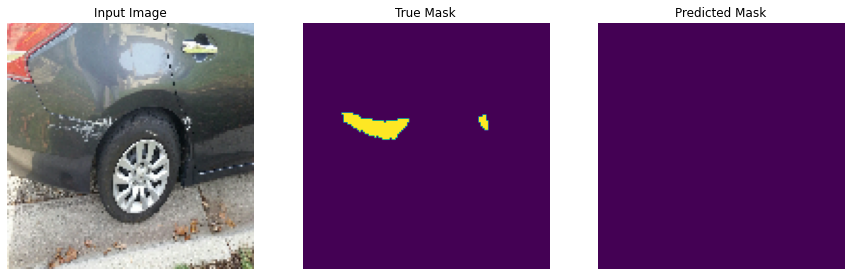


Sample Prediction after epoch 6

7/7 [==============================] - 11s 2s/step - loss: 0.6509 - dice_coef: 0.3357 - binary_accuracy: 0.8547 - val_loss: 0.9959 - val_dice_coef: 0.0034 - val_binary_accuracy: 0.9302


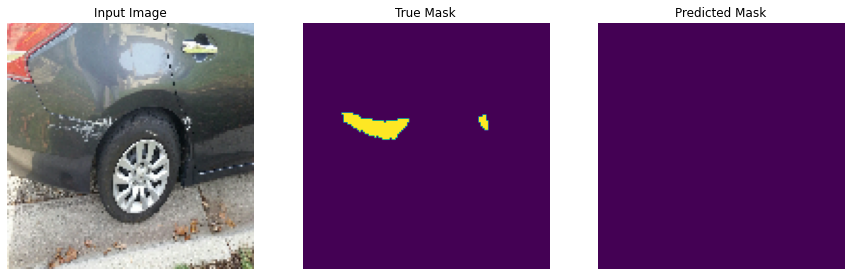


Sample Prediction after epoch 6

7/7 [==============================] - 11s 2s/step - loss: 0.6509 - dice_coef: 0.3357 - binary_accuracy: 0.8547 - val_loss: 0.9959 - val_dice_coef: 0.0034 - val_binary_accuracy: 0.9302
Epoch 7/100
Epoch 7/100
7/7 [==============================] - 9s 1s/step - loss: 0.6835 - dice_coef: 0.2875 - binary_accuracy: 0.8274 - val_loss: 0.9959 - val_dice_coef: 0.0034 - val_binary_accuracy: 0.9302
Epoch 8/100
Epoch 8/100
7/7 [==============================] - 9s 1s/step - loss: 0.6748 - dice_coef: 0.3888 - binary_accuracy: 0.8230 - val_loss: 0.9959 - val_dice_coef: 0.0034 - val_binary_accuracy: 0.9302
Epoch 9/100
Epoch 9/100
7/7 [==============================] - 9s 1s/step - loss: 0.6331 - dice_coef: 0.3483 - binary_accuracy: 0.8803 - val_loss: 0.9959 - val_dice_coef: 0.0034 - val_binary_accuracy: 0.9302
Epoch 10/100
Epoch 10/100
7/7 [==============================] - 9s 1s/step - loss: 0.6170 - dice_coef: 0.3769 - binary_accuracy: 0.9197 - val_loss: 0.9959 -

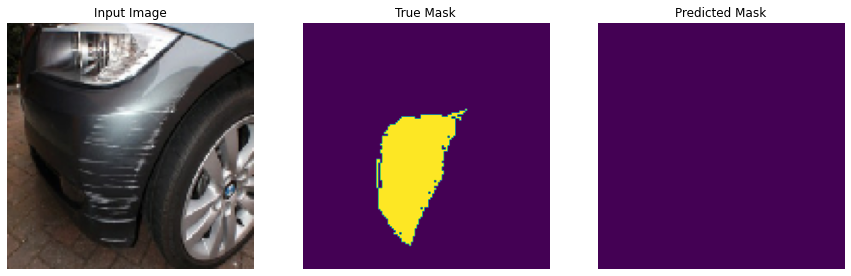

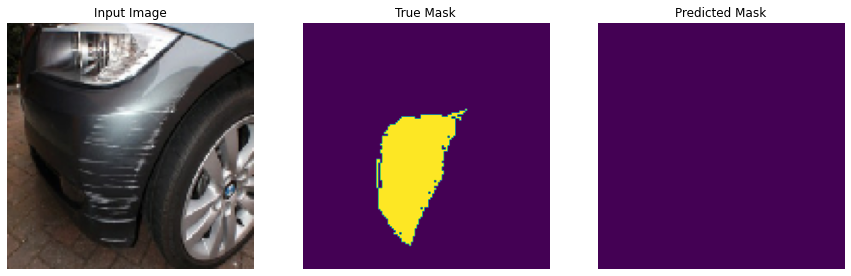


Sample Prediction after epoch 11

7/7 [==============================] - 11s 1s/step - loss: 0.5901 - dice_coef: 0.4182 - binary_accuracy: 0.8968 - val_loss: 0.9959 - val_dice_coef: 0.0034 - val_binary_accuracy: 0.9302

Sample Prediction after epoch 11

7/7 [==============================] - 11s 1s/step - loss: 0.5901 - dice_coef: 0.4182 - binary_accuracy: 0.8968 - val_loss: 0.9959 - val_dice_coef: 0.0034 - val_binary_accuracy: 0.9302
Epoch 12/100
Epoch 12/100
7/7 [==============================] - 9s 1s/step - loss: 0.5900 - dice_coef: 0.3779 - binary_accuracy: 0.9108 - val_loss: 0.9959 - val_dice_coef: 0.0034 - val_binary_accuracy: 0.9302
Epoch 13/100
Epoch 13/100
7/7 [==============================] - 10s 1s/step - loss: 0.5748 - dice_coef: 0.4168 - binary_accuracy: 0.9296 - val_loss: 0.9959 - val_dice_coef: 0.0034 - val_binary_accuracy: 0.9302
Epoch 14/100
Epoch 14/100
7/7 [==============================] - 10s 1s/step - loss: 0.5487 - dice_coef: 0.4137 - binary_accuracy: 0.9301 -

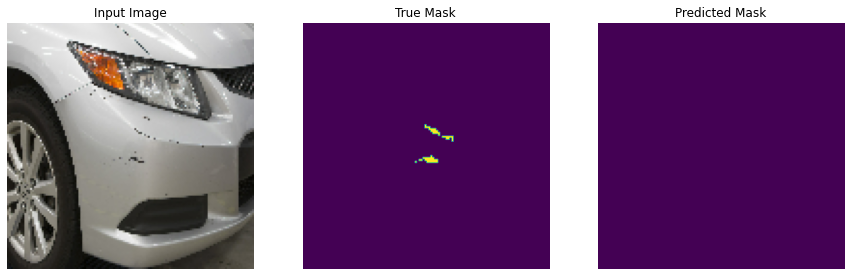

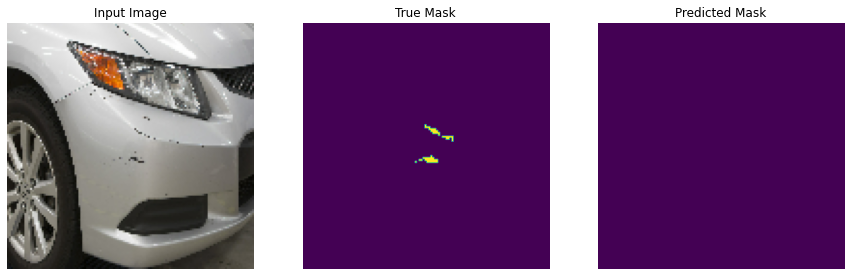


Sample Prediction after epoch 16

7/7 [==============================] - 10s 1s/step - loss: 0.6249 - dice_coef: 0.3587 - binary_accuracy: 0.8844 - val_loss: 0.9959 - val_dice_coef: 0.0034 - val_binary_accuracy: 0.9302

Sample Prediction after epoch 16

7/7 [==============================] - 10s 1s/step - loss: 0.6249 - dice_coef: 0.3587 - binary_accuracy: 0.8844 - val_loss: 0.9959 - val_dice_coef: 0.0034 - val_binary_accuracy: 0.9302
Epoch 17/100
Epoch 17/100
7/7 [==============================] - 9s 1s/step - loss: 0.5705 - dice_coef: 0.4401 - binary_accuracy: 0.9119 - val_loss: 0.9959 - val_dice_coef: 0.0034 - val_binary_accuracy: 0.9302
Epoch 18/100
Epoch 18/100
7/7 [==============================] - 9s 1s/step - loss: 0.5822 - dice_coef: 0.4226 - binary_accuracy: 0.9206 - val_loss: 0.9959 - val_dice_coef: 0.0034 - val_binary_accuracy: 0.9302
Epoch 19/100
Epoch 19/100
7/7 [==============================] - 13s 2s/step - loss: 0.5748 - dice_coef: 0.4540 - binary_accuracy: 0.9131 - 

C:\Users\DELL\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\DELL\anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
C:\Users\DELL\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\DELL\anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: 

In [19]:
model_history, trained_unet_model = build_and_train_unet_model(train_processed_image_ds, val_processed_image_ds)
save_trained_model(trained_unet_model)

## Ploting performance

In [20]:
def plot_model_results(model_history):
    """
    Plots binary accuracy and dice co-efficients for training and validation dataset using matplotlib library

    Argument:
    model_history -- a keras model history object containg details about model performance 

    """
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title('Binary accuracy')
    plt.plot(model_history.history["binary_accuracy"])
    plt.plot(model_history.history["val_binary_accuracy"])
    plt.legend(['accuracy','val_accuracy'])
    
    plt.subplot(1, 2, 2)
    plt.title('Dice co-efficient')
    plt.plot(model_history.history["dice_coef"])
    plt.plot(model_history.history["val_dice_coef"])
    plt.legend(['dice_coef','val_dice_coef'])

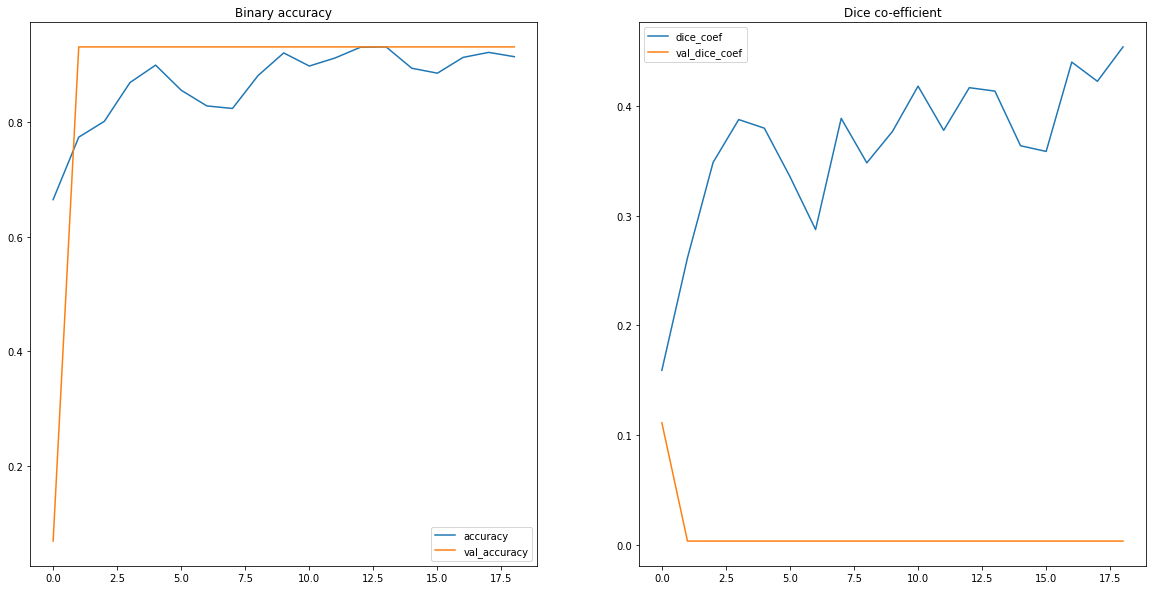

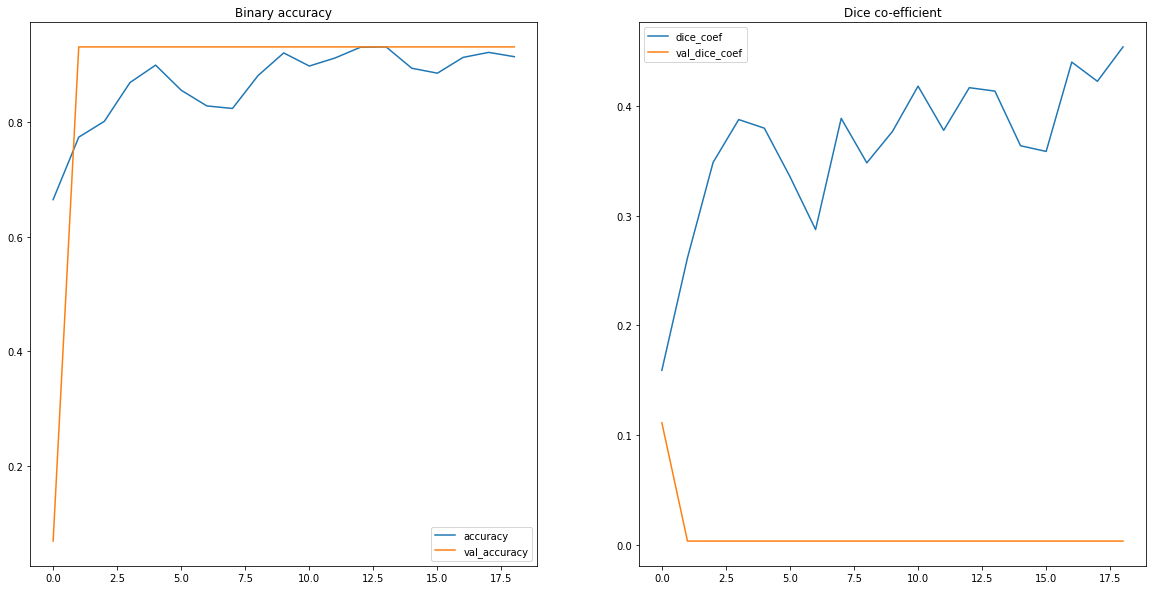

In [21]:
plot_model_results(model_history)

## Testing the model

In [22]:
def display(display_list):
    """
    Displays the predicted masks.

    Argument:
    display_list -- A list of masks predicted by the model

    """

    plt.figure(figsize=(15, 15))

    for index, display_item in enumerate(display_list):
        plt.subplot(1, len(display_list), index+1)
        title = display_item['title']
        plt.title(title)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_item['mask']))
        plt.axis('off')
    plt.show()

In [23]:
def create_mask(pred_mask):
    """
    Create a mask by taking the largest number in the predicted tensor from the model.

    Argument:
    pred_mask -- A tensor returned by model after prediction

    Returns:
    pred_mask -- A tensor having only filled with largest argument in the channel axis.

    """

    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [24]:
def show_predictions(test_image_path_list, model):
    """
    Displays the image that was predicted by the trained model for test dataset.

    Argument:
    test_image_path_list -- list of location where test images resides
    model -- A trained model returned by build_and_train_unet_model function

    """

    masked_image = []
    for test_image_path in test_image_path_list:
        test_image, _ = process_path(test_image_path)
        processed_image, _ = preprocess(test_image)
        processed_image = tf.expand_dims(processed_image, axis=0)
        pred_mask = model.predict(processed_image)
        temp_image = {
            'title': test_image_path.split('/')[-1],
            'mask': create_mask(pred_mask)
        }
        masked_image.append(temp_image)
        
    display(masked_image)

In [25]:
def test_model(test_folder_path, trained_unet_model):
    """
    Test the trained model on test dataset.

    Arguments:
    test_folder_path -- string having location where test dataset resides.
    trained_unet_model -- A trained model returned by build_and_train_unet_model function

    """

    test_image_path_list = os.listdir(test_folder_path)

    test_image_path_list = [os.path.join(test_folder_path, i) for i in test_image_path_list]

    show_predictions(test_image_path_list, trained_unet_model)

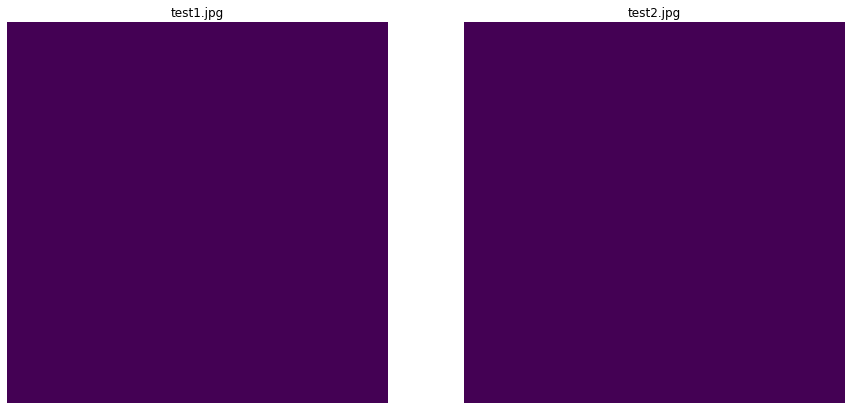

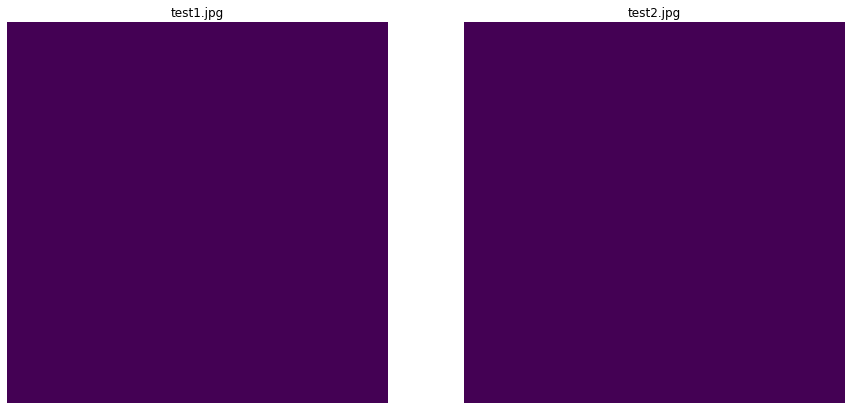

In [26]:
test_model(test_folder_path, trained_unet_model)